# Proyecto de Clasificación de Crímenes en Nueva York

## Introducción

El objetivo de este proyecto es trabajar con datos públicos del departamento de policía de New York, específicamente información sobre interrogaciones y detenciones realizadas en la vía pública. Se utilizará la data del año 2009 como conjunto de entrenamiento y la del año 2010 como conjunto de pruebas. El análisis se centrará en:

- Se desarrollarán dos modelos predictivos para determinar si un procedimiento policial concluirá en un arresto y si concluirá en alguna acción violenta.
- Se reportará la probabilidad de que un individuo sea arrestado en uno de los cinco barrios o por pertenecer a una raza en particular.

In [ ]:
# Importaciones de bibliotecas
import warnings
import pickle
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Configuración de visualización
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set(style="white")

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análisis Exploratorio de Datos (EDA)


Descripción General del Conjunto de Datos
- Número total de registros y variables.
- Descripción de las variables principales.

In [ ]:
import os

# Define las rutas de los archivos CSV
base_path = '/content/drive/MyDrive/Portafolio/ML Clasificación - Crímenes New York/'
archivo_csv_2009 = os.path.join(base_path, '2009_1perc.csv')
archivo_csv_2010 = os.path.join(base_path, '2010_1perc.csv')

# Carga y procesamiento de datos
df_original_2009 = pd.read_csv(archivo_csv_2009).drop(columns='Unnamed: 0')
df_original_2010 = pd.read_csv(archivo_csv_2010).drop(columns='Unnamed: 0')

# Concatenación de DataFrames
df_concatenado = pd.concat([df_original_2009, df_original_2010]).reset_index(drop=True)

In [ ]:
shape_info = df_concatenado.shape
print("La forma del DataFrame concatenado es:", shape_info)

La forma del DataFrame concatenado es: (11825, 111)


In [ ]:
var_arresto=['arstmade','crimsusp','rf_vcrim']
var_violencia=['asltweap','contrabn','knifcuti','machgun','othrweap','pistol','rf_othsw','riflshot','pf_baton','pf_drwep','pf_grnd','pf_hands','pf_hcuff','pf_other','pf_pepsp','pf_ptwep','pf_wall']

In [ ]:
for variable in var_arresto:
    unique_values_count = len(df_concatenado[variable].unique())
    print(f'{variable}: {unique_values_count} valores únicos')

arstmade: 2 valores únicos
crimsusp: 660 valores únicos
rf_vcrim: 2 valores únicos


In [ ]:
for variable in var_violencia:
    unique_values_count = len(df_concatenado[variable].unique())
    print(f'{variable}: {unique_values_count} valores únicos')

asltweap: 2 valores únicos
contrabn: 2 valores únicos
knifcuti: 2 valores únicos
machgun: 1 valores únicos
othrweap: 2 valores únicos
pistol: 2 valores únicos
rf_othsw: 2 valores únicos
riflshot: 2 valores únicos
pf_baton: 2 valores únicos
pf_drwep: 2 valores únicos
pf_grnd: 2 valores únicos
pf_hands: 2 valores únicos
pf_hcuff: 2 valores únicos
pf_other: 2 valores únicos
pf_pepsp: 2 valores únicos
pf_ptwep: 2 valores únicos
pf_wall: 2 valores únicos


In [ ]:
archivo_dic = os.path.join(base_path, '2009 SQF File Spec.xlsx')
diccionario = pd.read_excel(archivo_dic)
print(diccionario)

     Variable  Position                             Label Measurement Level
0        year         1               YEAR OF STOP (CCYY)           Nominal
1         pct         2  PRECINCT OF STOP (FROM 1 TO 123)           Nominal
2     ser_num         3               UF250 SERIAL NUMBER           Nominal
3    datestop         4         DATE OF STOP (MM-DD-YYYY)           Nominal
4    timestop         5              TIME OF STOP (HH:MM)             Scale
..        ...       ...                               ...               ...
106    xcoord       107          LOCATION OF STOP X COORD           Nominal
107    ycoord       108          LOCATION OF STOP Y COORD           Nominal
108  dettypcm       109                DETAILS TYPES CODE           Nominal
109    linecm       110       COUNT >1 ADDITIONAL DETAILS           Nominal
110  detailcm       111            CRIME CODE DESCRIPTION           Nominal

[111 rows x 4 columns]


Limpieza y Preprocesamiento de Datos
- Identificación y manejo de valores nulos o atípicos.
- Conversión de tipos de datos.
- Eliminación de variables irrelevantes o altamente desbalanceadas.

<Axes: >

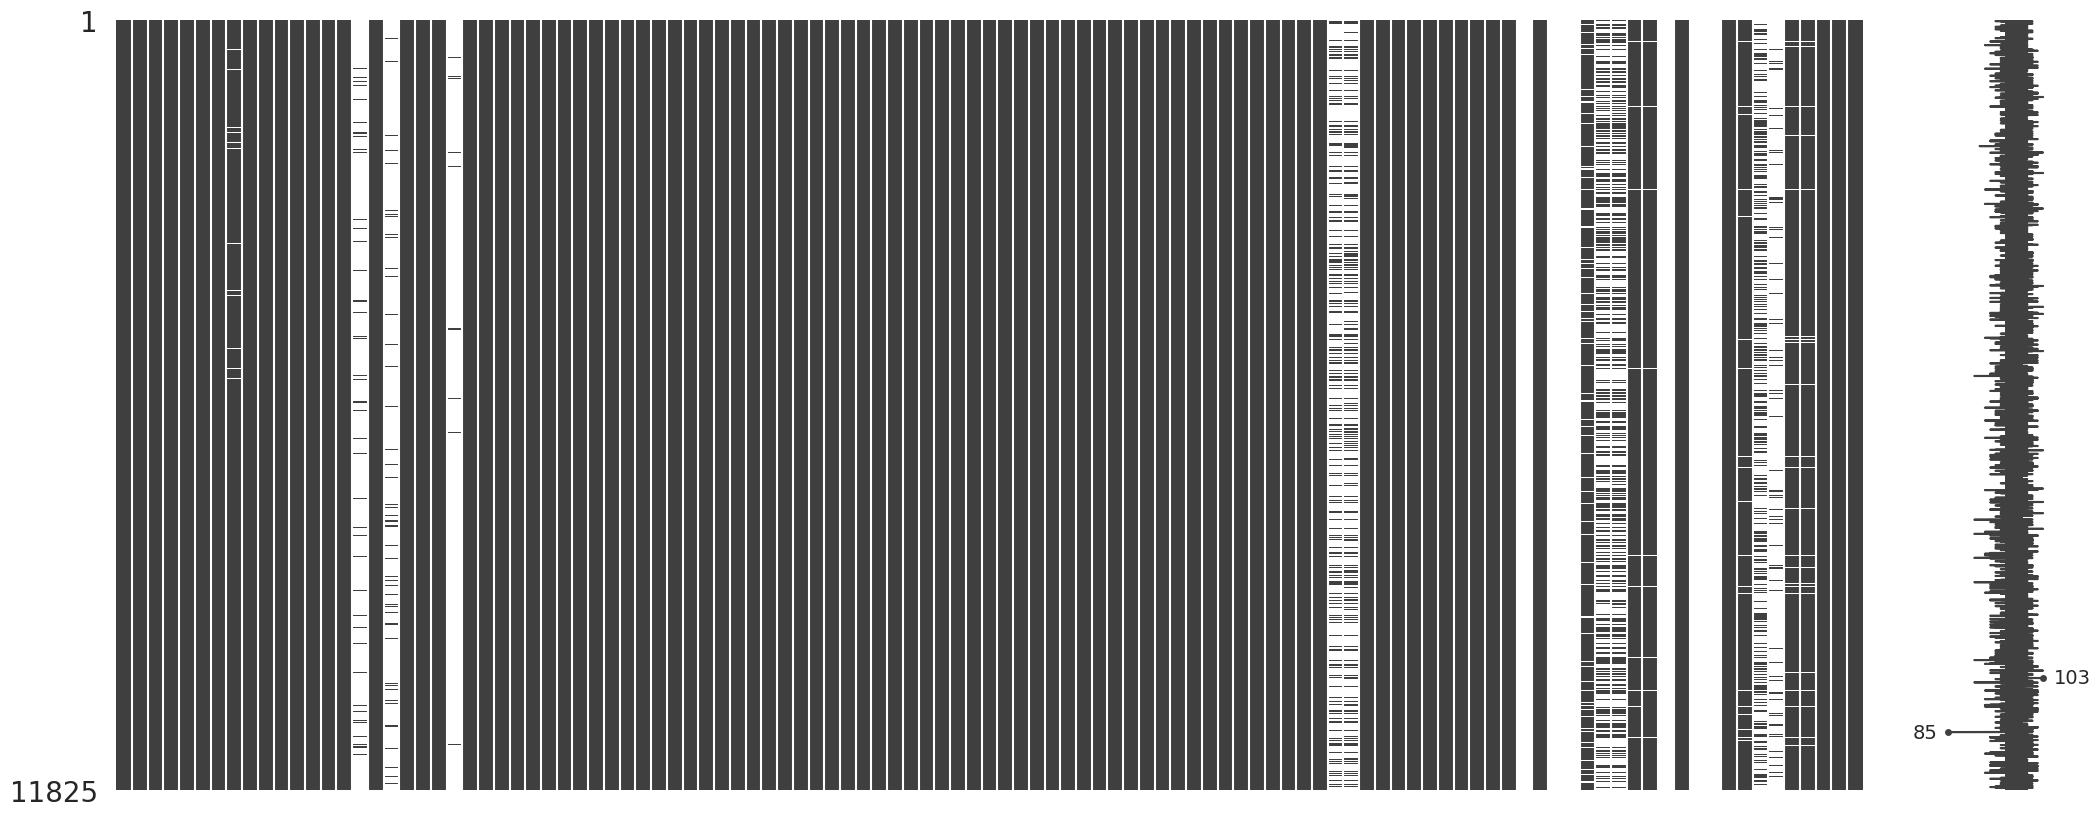

In [ ]:
# Reemplazar espacios en blanco por NaN
df_concatenado.replace(' ', np.NaN, inplace=True)

# Visualizar la matriz de valores nulos
msgn.matrix(df_concatenado)

In [ ]:
# Obtener información sobre valores nulos
nulos = df_concatenado.isna().sum()
porcentaje = round((df_concatenado.isna().sum() / len(df_concatenado)) * 100, 4)
conteo_nulos = pd.DataFrame({'Variable': nulos.index, 'Nulos': nulos.values, 'Porcentaje': porcentaje.values})
conteo_nulos = conteo_nulos[conteo_nulos['Nulos'] > 0].sort_values(by='Nulos', ascending=False)

# Mostrar el DataFrame resultante
print(conteo_nulos)

     Variable  Nulos  Porcentaje
92   premtype  11825    100.0000
89   othfeatr  11825    100.0000
98     aptnum  11825    100.0000
101       zip  11825    100.0000
91    rescode  11825    100.0000
100     state  11825    100.0000
21   officrid  11664     98.6385
15   arstoffn  11078     93.6829
17   sumoffen  11023     93.2178
105      post  10651     90.0719
77    offverb   9246     78.1903
78    offshld   8575     72.5159
104      beat   7444     62.9514
94    addrnum   6861     58.0211
95     stname   6693     56.6004
93   premname   1216     10.2833
107    ycoord    417      3.5264
106    xcoord    417      3.5264
103    sector    289      2.4440
7     trhsloc    205      1.7336
96    stinter    111      0.9387
97    crossst    110      0.9302
102   addrpct      1      0.0085
99       city      1      0.0085
90    addrtyp      1      0.0085
108  dettypcm      1      0.0085
109    linecm      1      0.0085
110  detailcm      1      0.0085


In [ ]:
# Filtrar variables con más del 50% de valores nulos
top_50_nulos = conteo_nulos[conteo_nulos['Porcentaje'] > 50]

# Mostrar el DataFrame resultante
print(top_50_nulos)

     Variable  Nulos  Porcentaje
92   premtype  11825    100.0000
89   othfeatr  11825    100.0000
98     aptnum  11825    100.0000
101       zip  11825    100.0000
91    rescode  11825    100.0000
100     state  11825    100.0000
21   officrid  11664     98.6385
15   arstoffn  11078     93.6829
17   sumoffen  11023     93.2178
105      post  10651     90.0719
77    offverb   9246     78.1903
78    offshld   8575     72.5159
104      beat   7444     62.9514
94    addrnum   6861     58.0211
95     stname   6693     56.6004


In [ ]:
# Eliminar columnas con más del 50% de valores nulos
df_concatenado_2 = df_concatenado.drop(columns=top_50_nulos['Variable'])

# Obtener información sobre valores nulos en el nuevo DataFrame
nulos_2 = df_concatenado_2.isna().sum()
porcentaje_2 = round((df_concatenado_2.isna().sum() / len(df_concatenado_2)) * 100, 4)
conteo_nulos_2 = pd.DataFrame({'Variable': nulos_2.index, 'Nulos': nulos_2.values, 'Porcentaje': porcentaje_2.values})
conteo_nulos_2 = conteo_nulos_2[conteo_nulos_2['Nulos'] > 0].sort_values(by='Nulos', ascending=False)

# Mostrar el DataFrame resultante
print(conteo_nulos_2)

    Variable  Nulos  Porcentaje
85  premname   1216     10.2833
91    xcoord    417      3.5264
92    ycoord    417      3.5264
90    sector    289      2.4440
7    trhsloc    205      1.7336
86   stinter    111      0.9387
87   crossst    110      0.9302
84   addrtyp      1      0.0085
88      city      1      0.0085
89   addrpct      1      0.0085
93  dettypcm      1      0.0085
94    linecm      1      0.0085
95  detailcm      1      0.0085


In [ ]:
# Contar las ocurrencias de cada valor único en la columna 'premname'
premname_counts = df_concatenado_2['premname'].value_counts()

# Mostrar el resultado
print(premname_counts)

STREET                4503
SIDEWALK              1682
LOBBY                  563
RESIDENTIAL            217
MEZZ                   212
                      ... 
F-TAP                    1
INSIDE OF BUILDING       1
TAVERAN                  1
FRONT PORCH              1
BOOTH N62K               1
Name: premname, Length: 1041, dtype: int64


In [ ]:
# Obtener los nombres de premname más frecuentes
top_premname = df_concatenado_2['premname'].value_counts().head(10).index.tolist()

# Identificar nombres de premname que no están en la lista de los más frecuentes
other_premname = df_concatenado_2['premname'].unique()
other_premname = [name for name in other_premname if name not in top_premname]

# Reemplazar nombres de premname menos frecuentes con 'OTHER'
df_concatenado_2['premname'] = np.where(df_concatenado_2['premname'].isin(other_premname), 'OTHER', df_concatenado_2['premname'])

# Llenar valores nulos con 'OTHER'
df_concatenado_2['premname'] = df_concatenado_2['premname'].fillna('OTHER')

# Contar las ocurrencias de cada valor único en la columna 'premname' después de la transformación
premname_counts_after_transformation = df_concatenado_2['premname'].value_counts()

# Mostrar el resultado
print(premname_counts_after_transformation)

STREET             4503
OTHER              3962
SIDEWALK           1682
LOBBY               563
RESIDENTIAL         217
MEZZ                212
PARK                209
PUBLIC SIDEWALK     143
HALLWAY             139
SUBWAY              102
COMMERCIAL           93
Name: premname, dtype: int64


<Axes: >

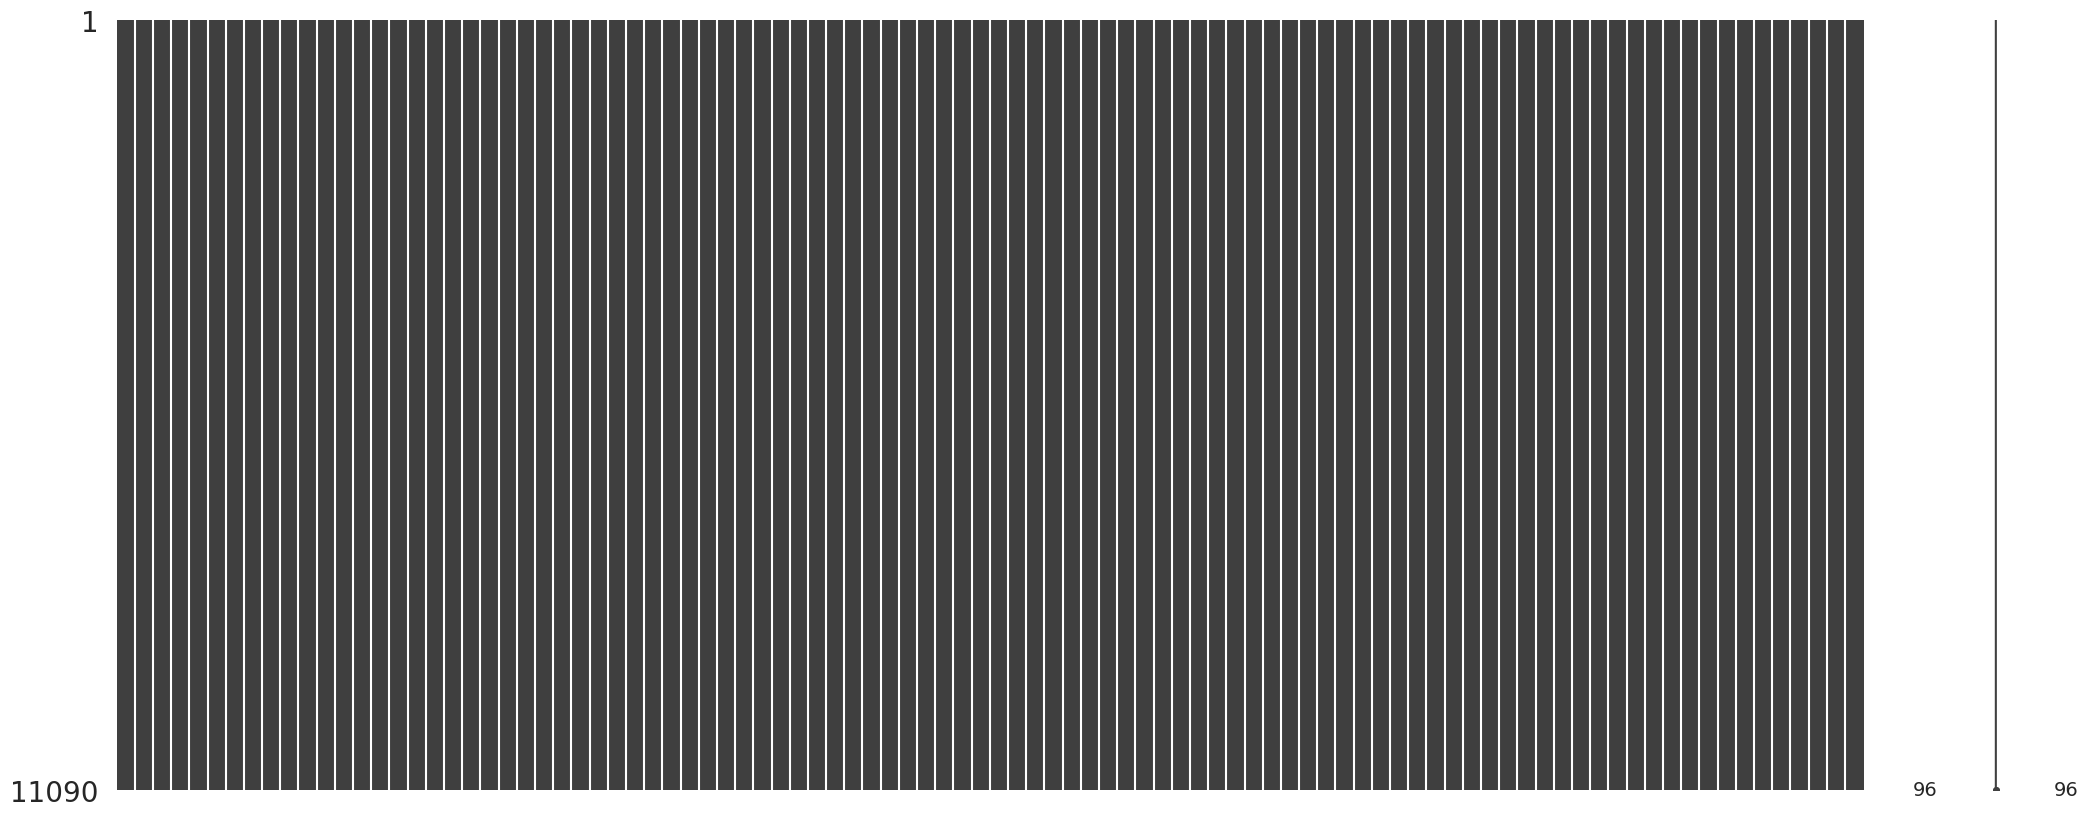

In [ ]:
# Eliminar filas con valores nulos
df_concatenado_2 = df_concatenado_2.dropna()

# Visualizar la matriz de valores nulos después de eliminarlos
msgn.matrix(df_concatenado_2)

Análisis de Variables
- Exploración de variables categóricas y numéricas.
- Visualización de distribuciones y relaciones.

In [ ]:
# Filtrar el diccionario para incluir solo las variables presentes en df_concatenado_2
diccionario_2 = diccionario[diccionario['Variable'].isin(df_concatenado_2.columns)]

# Mostrar el DataFrame resultante
print(diccionario_2)

     Variable  Position                             Label Measurement Level
0        year         1               YEAR OF STOP (CCYY)           Nominal
1         pct         2  PRECINCT OF STOP (FROM 1 TO 123)           Nominal
2     ser_num         3               UF250 SERIAL NUMBER           Nominal
3    datestop         4         DATE OF STOP (MM-DD-YYYY)           Nominal
4    timestop         5              TIME OF STOP (HH:MM)             Scale
..        ...       ...                               ...               ...
106    xcoord       107          LOCATION OF STOP X COORD           Nominal
107    ycoord       108          LOCATION OF STOP Y COORD           Nominal
108  dettypcm       109                DETAILS TYPES CODE           Nominal
109    linecm       110       COUNT >1 ADDITIONAL DETAILS           Nominal
110  detailcm       111            CRIME CODE DESCRIPTION           Nominal

[96 rows x 4 columns]


In [ ]:
# Obtener el número de valores únicos por columna
num_valores_unicos = df_concatenado_2.nunique()

# Identificar las columnas con un único valor único
columnas_a_eliminar = num_valores_unicos[num_valores_unicos == 1].index

# Eliminar las columnas con un único valor único
df_concatenado_2 = df_concatenado_2.drop(columnas_a_eliminar, axis=1)

# Eliminar 'machgun' de la lista var_violencia
var_violencia.remove('machgun')

In [ ]:
# Filtrar diccionario_2 para incluir solo las variables presentes en df_concatenado_2
diccionario_2 = diccionario_2[diccionario_2['Variable'].isin(df_concatenado_2.columns)]

# Mostrar el DataFrame resultante
print(diccionario_2)

     Variable  Position                             Label Measurement Level
0        year         1               YEAR OF STOP (CCYY)           Nominal
1         pct         2  PRECINCT OF STOP (FROM 1 TO 123)           Nominal
2     ser_num         3               UF250 SERIAL NUMBER           Nominal
3    datestop         4         DATE OF STOP (MM-DD-YYYY)           Nominal
4    timestop         5              TIME OF STOP (HH:MM)             Scale
..        ...       ...                               ...               ...
103    sector       104           LOCATION OF STOP SECTOR           Nominal
106    xcoord       107          LOCATION OF STOP X COORD           Nominal
107    ycoord       108          LOCATION OF STOP Y COORD           Nominal
109    linecm       110       COUNT >1 ADDITIONAL DETAILS           Nominal
110  detailcm       111            CRIME CODE DESCRIPTION           Nominal

[90 rows x 4 columns]


In [ ]:
# Contar las ocurrencias de cada valor único en la columna 'crimsusp'
crimsusp_counts_top20 = df_concatenado_2['crimsusp'].value_counts().head(20)

# Mostrar los 20 principales
print(crimsusp_counts_top20)

FEL                  1673
CPW                  1501
MISD                 1270
FELONY                988
ROBBERY               874
GLA                   595
BURGLARY              460
CRIM TRES             320
CRIMINAL TRESPASS     227
ASSAULT               207
CPM                   193
GRAND LARCENY         169
CPCS                  167
BURG                  161
MIS                   128
PETIT LARCENY         119
CSCS                  115
CRIM TRESS             87
ROB                    68
GRAFFITI               62
Name: crimsusp, dtype: int64


In [ ]:
# Mapear valores específicos a categorías más generales
crimsusp_mapping = {
    'FEL': 'FELONY',
    'CRIM TRES': 'CRIMINAL TRESPASS',
    'CRIM TRESS': 'CRIMINAL TRESPASS',
    'CRIM TRESPASS': 'CRIMINAL TRESPASS',
    'ROB': 'ROBBERY',
    'ROBB': 'ROBBERY',
    'GLA': 'BURGLARY',
    'BURG': 'BURGLARY',
    'MIS': 'MISD'}

# Aplicar el mapeo a la columna 'crimsusp'
df_concatenado_2['crimsusp'] = df_concatenado_2['crimsusp'].replace(crimsusp_mapping)

# Identificar categorías menos frecuentes y agruparlas bajo 'OTHER'
top_crimsusp = df_concatenado_2['crimsusp'].value_counts().head(10).index.tolist()
other_crimsusp = [category for category in df_concatenado_2['crimsusp'].unique() if category not in top_crimsusp]

df_concatenado_2['crimsusp'] = np.where(df_concatenado_2['crimsusp'].isin(other_crimsusp), 'OTHER', df_concatenado_2['crimsusp'])

# Mostrar las 20 principales categorías después de las transformaciones
print(df_concatenado_2['crimsusp'].value_counts().head(20))

FELONY               2661
OTHER                1926
CPW                  1501
MISD                 1398
BURGLARY             1216
ROBBERY               985
CRIMINAL TRESPASS     667
ASSAULT               207
CPM                   193
GRAND LARCENY         169
CPCS                  167
Name: crimsusp, dtype: int64


In [ ]:
# Eliminar la variable 'crimsusp' de la lista var_arresto
var_arresto.remove('crimsusp')

In [ ]:
# Iterar sobre cada variable en var_arresto e imprimir las cuentas de valores únicos
for i in var_arresto:
    print(f'\n{i}:\n{df_concatenado_2[i].value_counts()}')


arstmade:
N    10390
Y      700
Name: arstmade, dtype: int64

rf_vcrim:
N    9808
Y    1282
Name: rf_vcrim, dtype: int64


In [ ]:
# Crear una nueva columna 'var_arresto' e inicializarla con cadenas vacías
df_concatenado_2['var_arresto'] = ""

# Asignar 'Y' a 'var_arresto' si alguna variable en var_arresto tiene el valor 'Y'
for i in var_arresto:
    df_concatenado_2['var_arresto'] = np.where(df_concatenado_2[i] == 'Y', 'Y', df_concatenado_2['var_arresto'])

# Asignar 'N' a 'var_arresto' si no hay ninguna variable en var_arresto con el valor 'Y'
df_concatenado_2['var_arresto'] = np.where(df_concatenado_2['var_arresto'] != 'Y', 'N', df_concatenado_2['var_arresto'])

# Contar las ocurrencias de 'Y' y 'N' en la columna 'var_arresto'
var_arresto_counts = df_concatenado_2['var_arresto'].value_counts()

# Mostrar el resultado
print(var_arresto_counts)

N    9213
Y    1877
Name: var_arresto, dtype: int64


In [ ]:
# Eliminar las variables en la lista var_arresto del DataFrame df_concatenado_2
df_concatenado_2 = df_concatenado_2.drop(var_arresto, axis=1)

In [ ]:
# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame()

# Iterar sobre cada variable en var_violencia
for i in var_violencia:
    # Obtener las cuentas de valores únicos
    cuenta_valores = df_concatenado_2[i].value_counts()

    # Agregar los resultados al DataFrame
    resultados_df = pd.concat([resultados_df, cuenta_valores.to_frame(name=i)], axis=1)

# Mostrar el DataFrame de resultados
print(resultados_df)

   asltweap  contrabn  knifcuti  othrweap  pistol  rf_othsw  riflshot  \
N     11089     10887     10987     11066   11079     10689     11088   
Y         1       203       103        24      11       401         2   

   pf_baton  pf_drwep  pf_grnd  pf_hands  pf_hcuff  pf_other  pf_pepsp  \
N     11085     11068    11032      8700     10686     11056     11088   
Y         5        22       58      2390       404        34         2   

   pf_ptwep  pf_wall  
N     11054    10696  
Y        36      394  


In [ ]:
# Crear una nueva columna 'var_violencia' e inicializarla con cadenas vacías
df_concatenado_2['var_violencia'] = ""

# Asignar 'Y' a 'var_violencia' si alguna variable en var_violencia tiene el valor 'Y'
for i in var_violencia:
    df_concatenado_2['var_violencia'] = np.where(df_concatenado_2[i] == 'Y', 'Y', df_concatenado_2['var_violencia'])

# Asignar 'N' a 'var_violencia' si no hay ninguna variable en var_violencia con el valor 'Y'
df_concatenado_2['var_violencia'] = np.where(df_concatenado_2['var_violencia'] != 'Y', 'N', df_concatenado_2['var_violencia'])

# Contar las ocurrencias de 'Y' y 'N' en la columna 'var_violencia'
var_violencia_counts = df_concatenado_2['var_violencia'].value_counts()

# Mostrar el resultado
print(var_violencia_counts)

N    8036
Y    3054
Name: var_violencia, dtype: int64


In [ ]:
# Eliminar las variables en la lista var_violencia del DataFrame df_concatenado_2
df_concatenado_2 = df_concatenado_2.drop(var_violencia, axis=1)

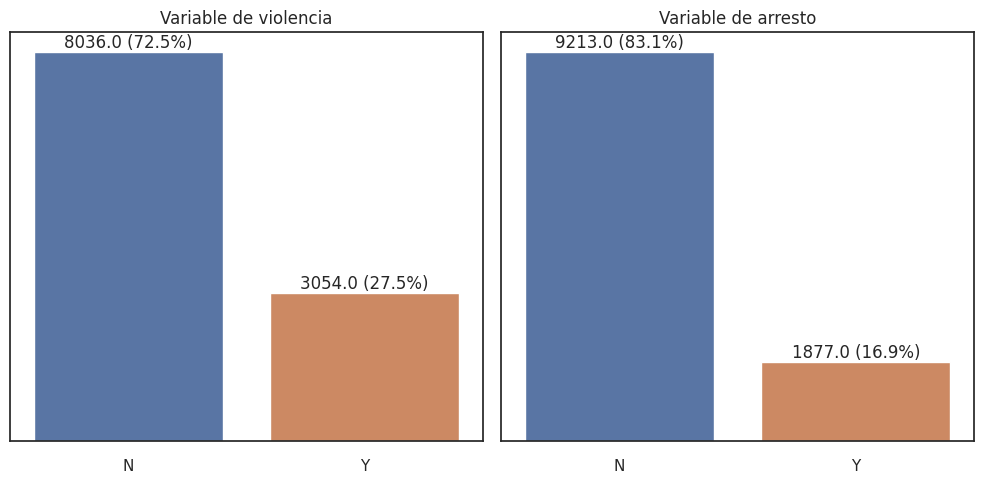

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 5))

# Subtrama 1: Variable de violencia
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df_concatenado_2, x='var_violencia')

# Agregar etiquetas con el número de ocurrencias y el porcentaje
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height, f'{height} ({height/len(df_concatenado_2)*100:.1f}%)', ha="center", va="bottom")

# Configuraciones adicionales para la subtrama 1
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('Variable de violencia')
ax1.set_yticks([])

# Subtrama 2: Variable de arresto
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=df_concatenado_2, x='var_arresto')

# Agregar etiquetas con el número de ocurrencias y el porcentaje
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height, f'{height} ({height/len(df_concatenado_2)*100:.1f}%)', ha="center", va="bottom")

# Configuraciones adicionales para la subtrama 2
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Variable de arresto')
ax2.set_yticks([])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar la visualización
plt.show()

In [ ]:
# Crear una lista para almacenar columnas desbalanceadas
columnas_desbalanceadas = []

# Iterar sobre cada columna en df_concatenado_2
for i in df_concatenado_2.columns:
    # Verificar si la columna es de tipo 'object' y si más del 90% de los valores pertenecen a una categoría
    if df_concatenado_2[i].dtype == 'object' and list(df_concatenado_2[i].value_counts())[0] / len(df_concatenado_2[i]) > 0.9:
        columnas_desbalanceadas.append(i)

# Eliminar columnas desbalanceadas del DataFrame df_concatenado_2
df_concatenado_2 = df_concatenado_2.drop(columnas_desbalanceadas, axis=1)

In [ ]:
# Filtrar las filas de diccionario_2 donde la variable está presente en las columnas de df_concatenado_2
diccionario_3 = diccionario_2.loc[diccionario_2['Variable'].isin(df_concatenado_2.columns)]

# Imprimir la forma (número de filas y columnas) de diccionario_3
print(diccionario_3.shape)

(50, 4)


In [ ]:
# Imprimir la forma (número de filas y columnas) de df_concatenado_2
print(df_concatenado_2.shape)

(11090, 52)


In [ ]:
# Mostrar las cuentas de valores únicos para la columna 'stinter'
print(df_concatenado_2['stinter'].value_counts())

BROADWAY             265
LEXINGTON AVENUE     156
8 AVENUE             124
3 AVENUE             115
7 AVENUE             111
                    ... 
NEHRING AVENUE         1
WEST 5 STREET          1
WASHINGTON CIRCLE      1
SHELL ROAD             1
ARDEN AVENUE           1
Name: stinter, Length: 2083, dtype: int64


In [ ]:
# Mostrar las cuentas de valores únicos para la columna 'crossst'
print(df_concatenado_2['crossst'].value_counts())

BROADWAY               107
PARK AVENUE            102
ROCKAWAY AVENUE         99
WEST 42 STREET          84
NOSTRAND AVENUE         76
                      ... 
HALLECK STREET           1
NELSON STREET            1
CENTRAL PARK NORTH       1
HURST STREET             1
DRUMGOOLE ROAD WEST      1
Name: crossst, Length: 2199, dtype: int64


In [ ]:
# Eliminar las columnas 'stinter' y 'crossst' del DataFrame df_concatenado_2
df_concatenado_2 = df_concatenado_2.drop(['stinter', 'crossst'], axis=1)

In [ ]:
# Lista de columnas a convertir a tipo de datos entero
columnas_entero = ['xcoord', 'ycoord', 'addrpct', 'detailcm']

# Aplicar la conversión a tipo de datos entero para todas las columnas en la lista
df_concatenado_2[columnas_entero] = df_concatenado_2[columnas_entero].astype(int)

In [ ]:
# Listas de variables según su categoría
var_caracteristica = ['age', 'build', 'dob', 'haircolr', 'ht_feet', 'ht_inch', 'inout', 'race', 'recstat', 'trhsloc', 'weight', 'eyecolor']
var_policia = ['offunif', 'radio', 'repcmd', 'revcmd']
var_localizacion = ['addrpct', 'city', 'pct', 'premname', 'sector', 'xcoord', 'ycoord']
var_otro = ['ac_cgdir', 'ac_evasv', 'ac_incid', 'ac_inves', 'ac_proxm', 'ac_rept', 'ac_time', 'detailcm', 'othpers', 'ser_num', 'typeofid', 'linecm']
var_registro = ['crimsusp', 'cs_casng', 'cs_descr', 'cs_furtv', 'cs_lkout', 'cs_other', 'frisked', 'rf_furt']
var_tiempo = ['datestop', 'perobs', 'perstop', 'timestop']

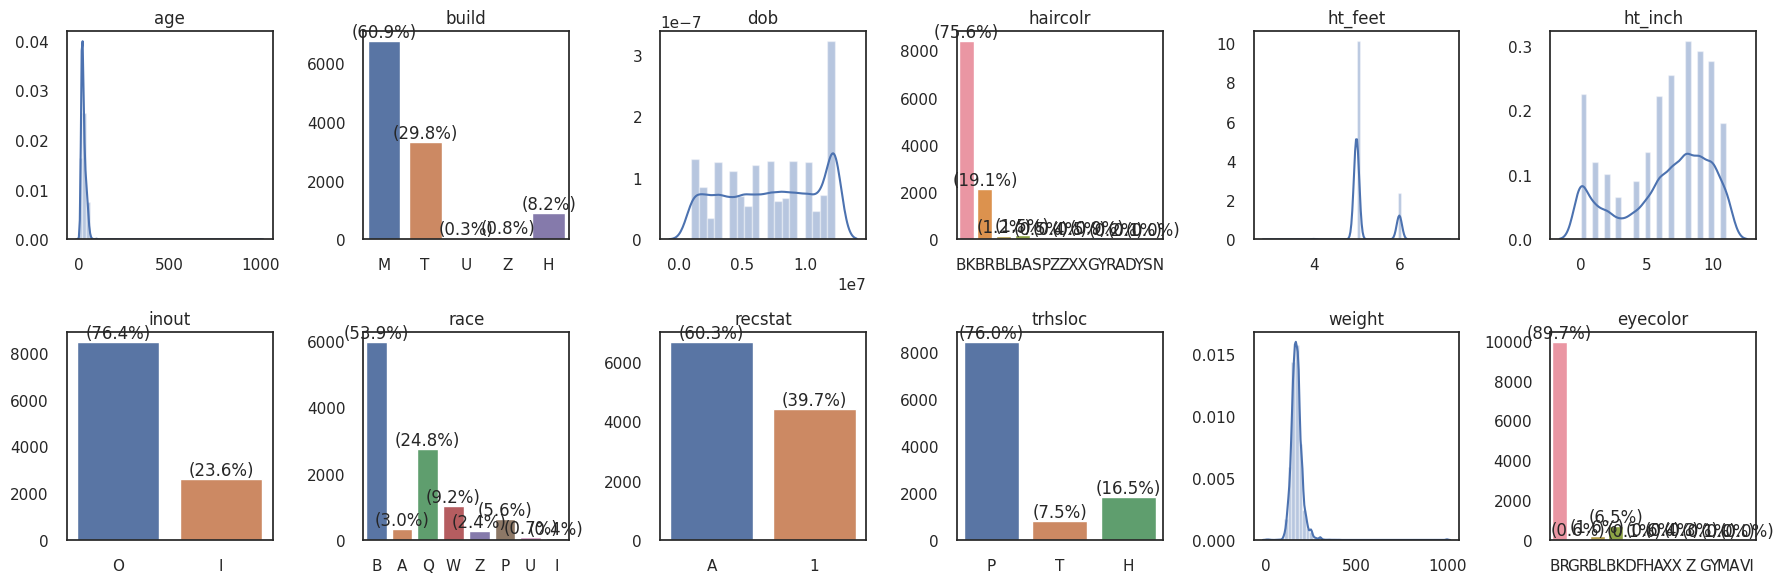

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 6))

# Iterar sobre las variables en var_caracteristica
for index, value in enumerate(var_caracteristica):
    # Crear subgráficos
    plt.subplot(2, 6, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

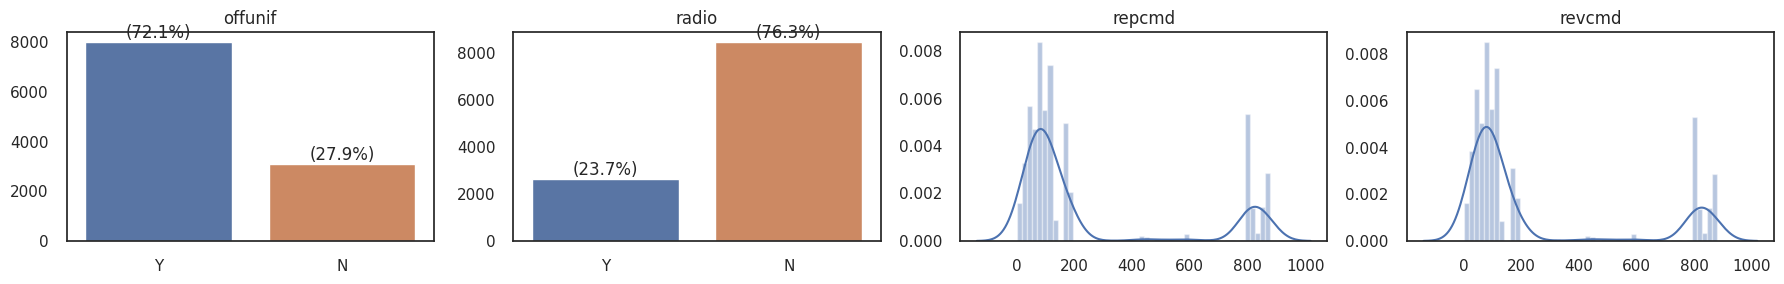

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 3))

# Iterar sobre las variables en var_policia
for index, value in enumerate(var_policia):
    # Crear subgráficos
    plt.subplot(1, 4, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

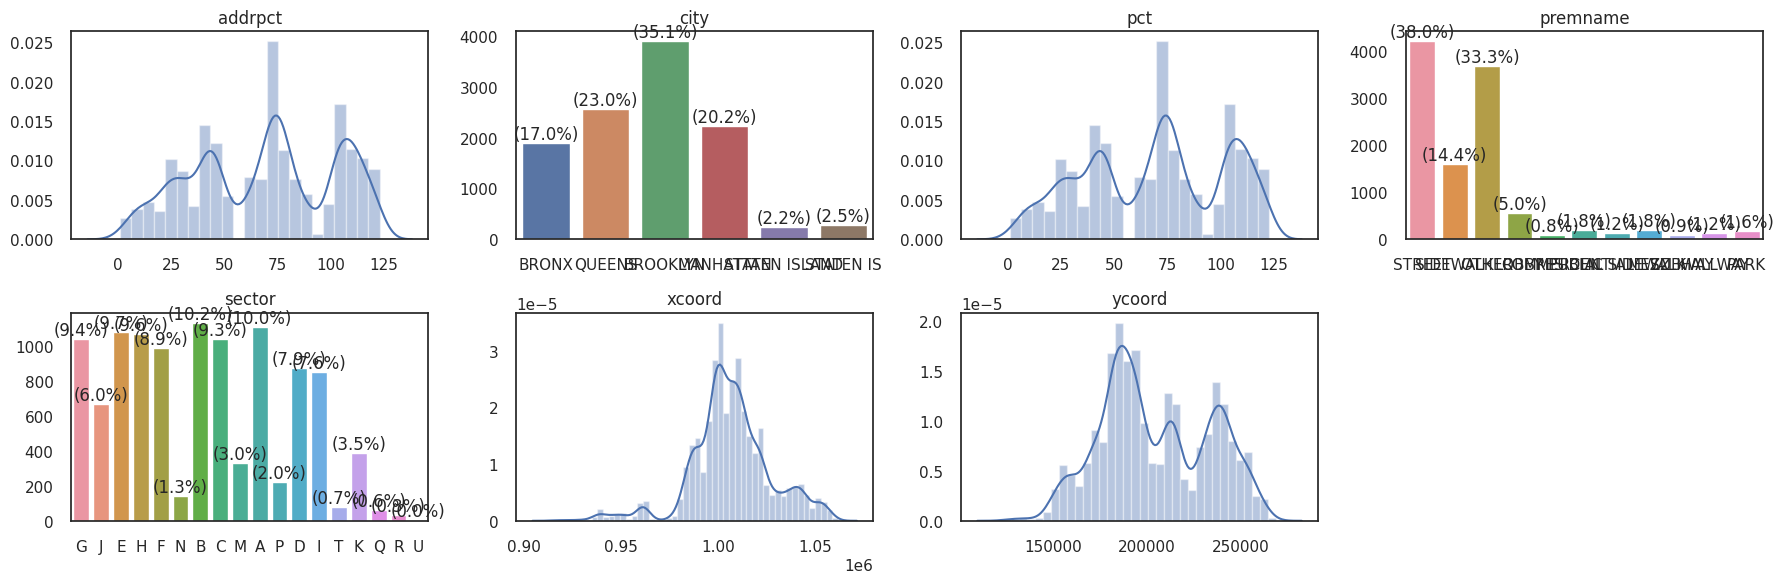

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 6))

# Iterar sobre las variables en var_localizacion
for index, value in enumerate(var_localizacion):
    # Crear subgráficos
    plt.subplot(2, 4, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

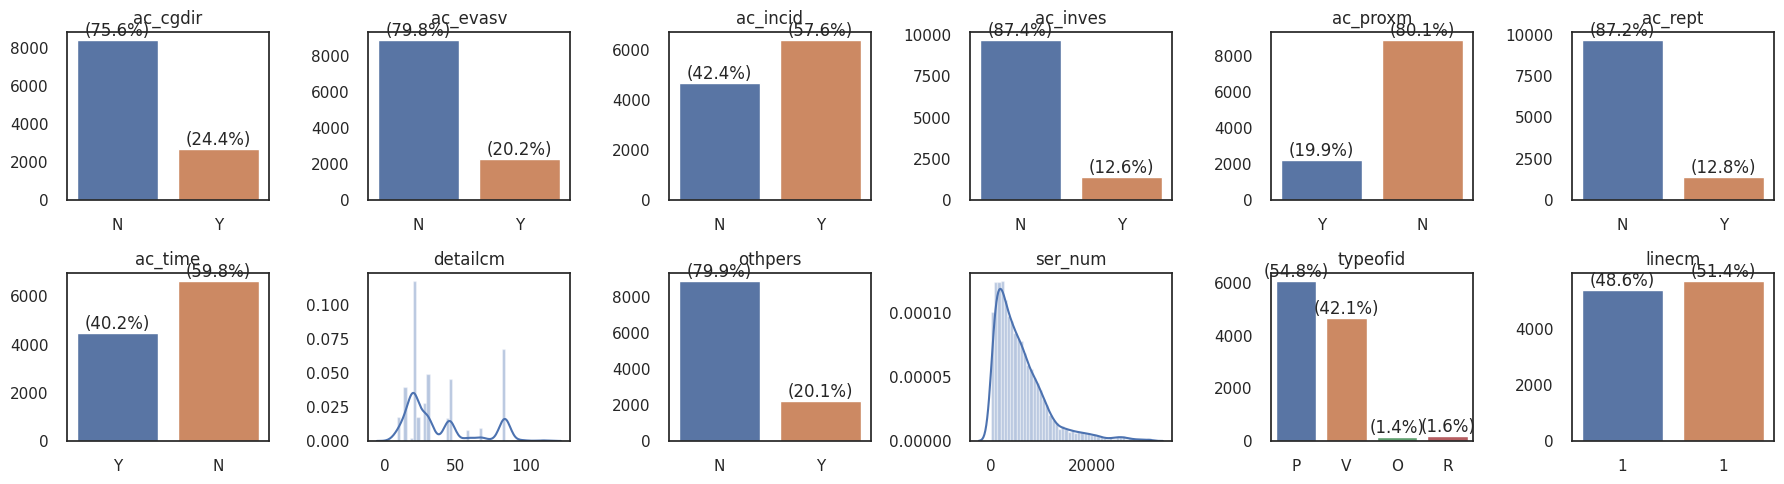

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 5))

# Iterar sobre las variables en var_otro
for index, value in enumerate(var_otro):
    # Crear subgráficos
    plt.subplot(2, 6, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

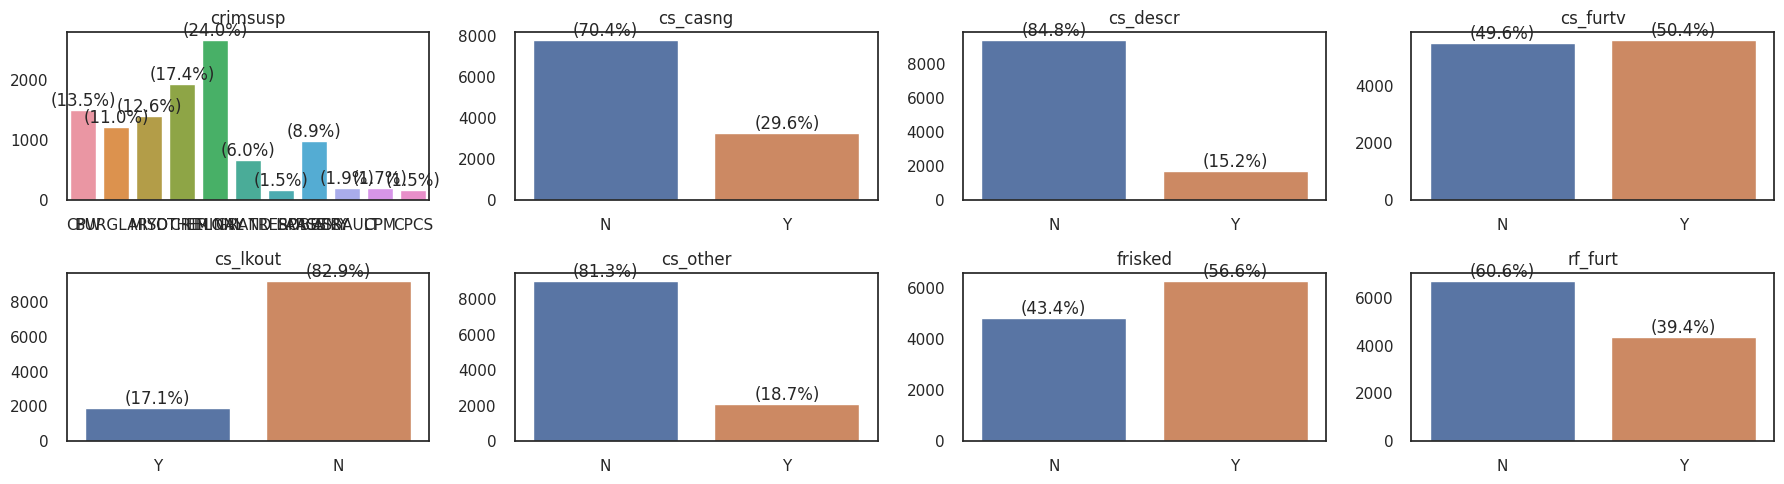

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 5))

# Iterar sobre las variables en var_registro
for index, value in enumerate(var_registro):
    # Crear subgráficos
    plt.subplot(2, 4, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

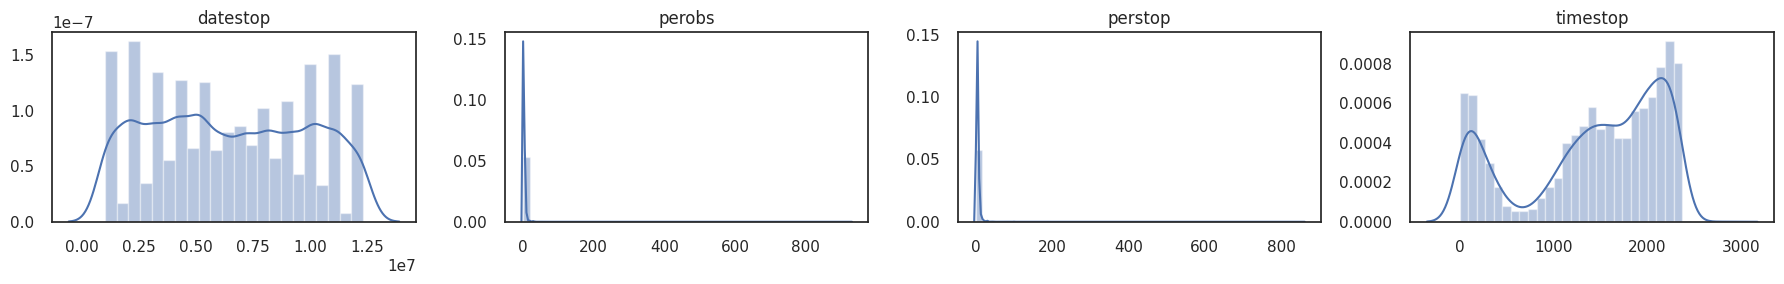

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(18, 3))

# Iterar sobre las variables en var_tiempo
for index, value in enumerate(var_tiempo):
    # Crear subgráficos
    plt.subplot(1, 4, index + 1)

    # Verificar si la variable es de tipo 'object'
    if df_concatenado_2[value].dtype == 'object':
        # Graficar un countplot para variables categóricas
        ax1 = sns.countplot(data=df_concatenado_2, x=value)
        for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x() + p.get_width() / 2., height, f'({height / len(df_concatenado_2) * 100:.1f}%)',
                     ha="center", va="bottom")
    else:
        # Graficar un distplot para variables numéricas
        sns.distplot(df_concatenado_2[value])

    # Establecer título y ajustar el diseño
    plt.title(value)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

# Mostrar la figura
plt.show()

In [ ]:
# Filtrar observaciones por número de personas observadas (perobs) entre 1 y 10
df_concatenado_2 = df_concatenado_2[(df_concatenado_2['perobs'] >= 1) & (df_concatenado_2['perobs'] <= 10)]

# Filtrar observaciones por número de personas detenidas (perstop) menor o igual a 15
df_concatenado_2 = df_concatenado_2[df_concatenado_2['perstop'] <= 15]

# Filtrar observaciones por edad (age) menor o igual a 70
df_concatenado_2 = df_concatenado_2[df_concatenado_2['age'] <= 70]

# Agrupar colores de cabello que no son 'BK' ni 'BR' en la categoría 'OTHER'
df_concatenado_2.loc[~df_concatenado_2['haircolr'].isin(['BK', 'BR']), 'haircolr'] = 'OTHER'

# Agrupar colores de ojos que no son 'BK' ni 'BR' en la categoría 'OTHER'
df_concatenado_2.loc[~df_concatenado_2['eyecolor'].isin(['BK', 'BR']), 'eyecolor'] = 'OTHER'

# Reemplazar 'STATEN IS' por 'STATEN ISLAND' en la columna 'city'
df_concatenado_2['city'] = np.where(df_concatenado_2['city'] == 'STATEN IS', 'STATEN ISLAND', df_concatenado_2['city'])

In [ ]:
# Verificar las dimensiones del DataFrame después de las operaciones de filtrado y manipulación
df_concatenado_2.shape

(10548, 50)

In [ ]:
# Imprimir el porcentaje de datos y el número de variables después de la limpieza
print(f'Luego de la limpieza de datos nos quedamos con el {round(len(df_concatenado_2)/len(df_concatenado),4)*100}% de la data original y {len(df_concatenado_2.columns)} de {len(df_concatenado.columns)} variables')

Luego de la limpieza de datos nos quedamos con el 89.2% de la data original y 50 de 111 variables


## Ingeniería de Características

Transformación de Variables
- Codificación de variables categóricas.
- Escalado de variables numéricas.

In [ ]:
# Imprimir información del DataFrame después de la limpieza
df_concatenado_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10548 entries, 0 to 11824
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           10548 non-null  int64  
 1   pct            10548 non-null  int64  
 2   ser_num        10548 non-null  int64  
 3   datestop       10548 non-null  int64  
 4   timestop       10548 non-null  int64  
 5   recstat        10548 non-null  object 
 6   inout          10548 non-null  object 
 7   trhsloc        10548 non-null  object 
 8   perobs         10548 non-null  float64
 9   crimsusp       10548 non-null  object 
 10  perstop        10548 non-null  int64  
 11  typeofid       10548 non-null  object 
 12  othpers        10548 non-null  object 
 13  offunif        10548 non-null  object 
 14  frisked        10548 non-null  object 
 15  radio          10548 non-null  object 
 16  ac_rept        10548 non-null  object 
 17  ac_inves       10548 non-null  object 
 18  ac_pro

In [ ]:
# Crear una copia del DataFrame df_concatenado_2
df3 = df_concatenado_2.copy()

# Imprimir las dimensiones de la copia
df3.shape

(10548, 50)

In [ ]:
# Inicializar listas para columnas de tipo 'object' y no 'object'
columnas_object = []
columnas_no_object = []

# Iterar sobre las columnas del DataFrame df3
for index, (colname, serie) in enumerate(df3.iteritems()):
    # Verificar el tipo de datos de la serie en cada columna
    if serie.dtype == 'object':
        columnas_object.append(colname)
    else:
        columnas_no_object.append(colname)

In [ ]:
# Iterar sobre las columnas de tipo 'object'
for i in columnas_object:
    # Utilizar get_dummies para codificar one-hot y agregar al DataFrame
    df3 = pd.concat([df3, pd.get_dummies(df3[i], drop_first=True, prefix=i)], axis=1).drop(columns=i)

# Imprimir las dimensiones del DataFrame después de la codificación one-hot
df3.shape

(10548, 101)

In [ ]:
def tabla_corr(corr_mat):
    # Apilar la matriz de correlación y resetear el índice
    corr_mat = corr_mat.stack().reset_index()

    # Renombrar las columnas
    corr_mat.columns = ['variable_1', 'variable_2', 'r']

    # Filtrar para excluir las correlaciones de una variable consigo misma
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]

    # Calcular el valor absoluto de la correlación
    corr_mat['abs_r'] = round(np.abs(corr_mat['r']), 4)

    # Eliminar la columna original de correlación (r)
    corr_mat.drop('r', axis=1, inplace=True)

    # Ordenar por valor absoluto de la correlación de forma descendente
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return corr_mat

# Aplicar la función a la matriz de correlación de df3
tabla_corr_df3 = tabla_corr(df3.corr())

# Filtrar correlaciones con valor absoluto mayor que 0.7
tabla_corr_filtrada = tabla_corr_df3[tabla_corr_df3['abs_r'] > 0.7].copy()

# Obtener las columnas consideradas en las correlaciones filtradas
columnas_consideradas = pd.unique(list(tabla_corr_filtrada['variable_1']) + list(tabla_corr_filtrada['variable_2']))

# Imprimir la tabla de correlaciones filtrada
tabla_corr_filtrada

,variable_1,variable_2,abs_r
98,year,linecm_1,1.0000
1415,addrpct,pct,1.0000
115,pct,addrpct,1.0000
9898,linecm_1,year,1.0000
715,repcmd,revcmd,0.9866
815,revcmd,repcmd,0.9866
3266,typeofid_P,typeofid_V,0.9416
3466,typeofid_V,typeofid_P,0.9416
2028,trhsloc_P,revcmd,0.8322
828,revcmd,trhsloc_P,0.8322


In [ ]:
# Eliminar columnas específicas del DataFrame df3
df3 = df3.drop(['linecm_1', 'detailcm', 'addrpct', 'revcmd', 'typeofid_V', 'build_M', 'ht_inch', 'recstat_A', 'trhsloc_P'], axis=1)

# Imprimir las dimensiones del DataFrame después de la eliminación de columnas
df3.shape

(10548, 92)

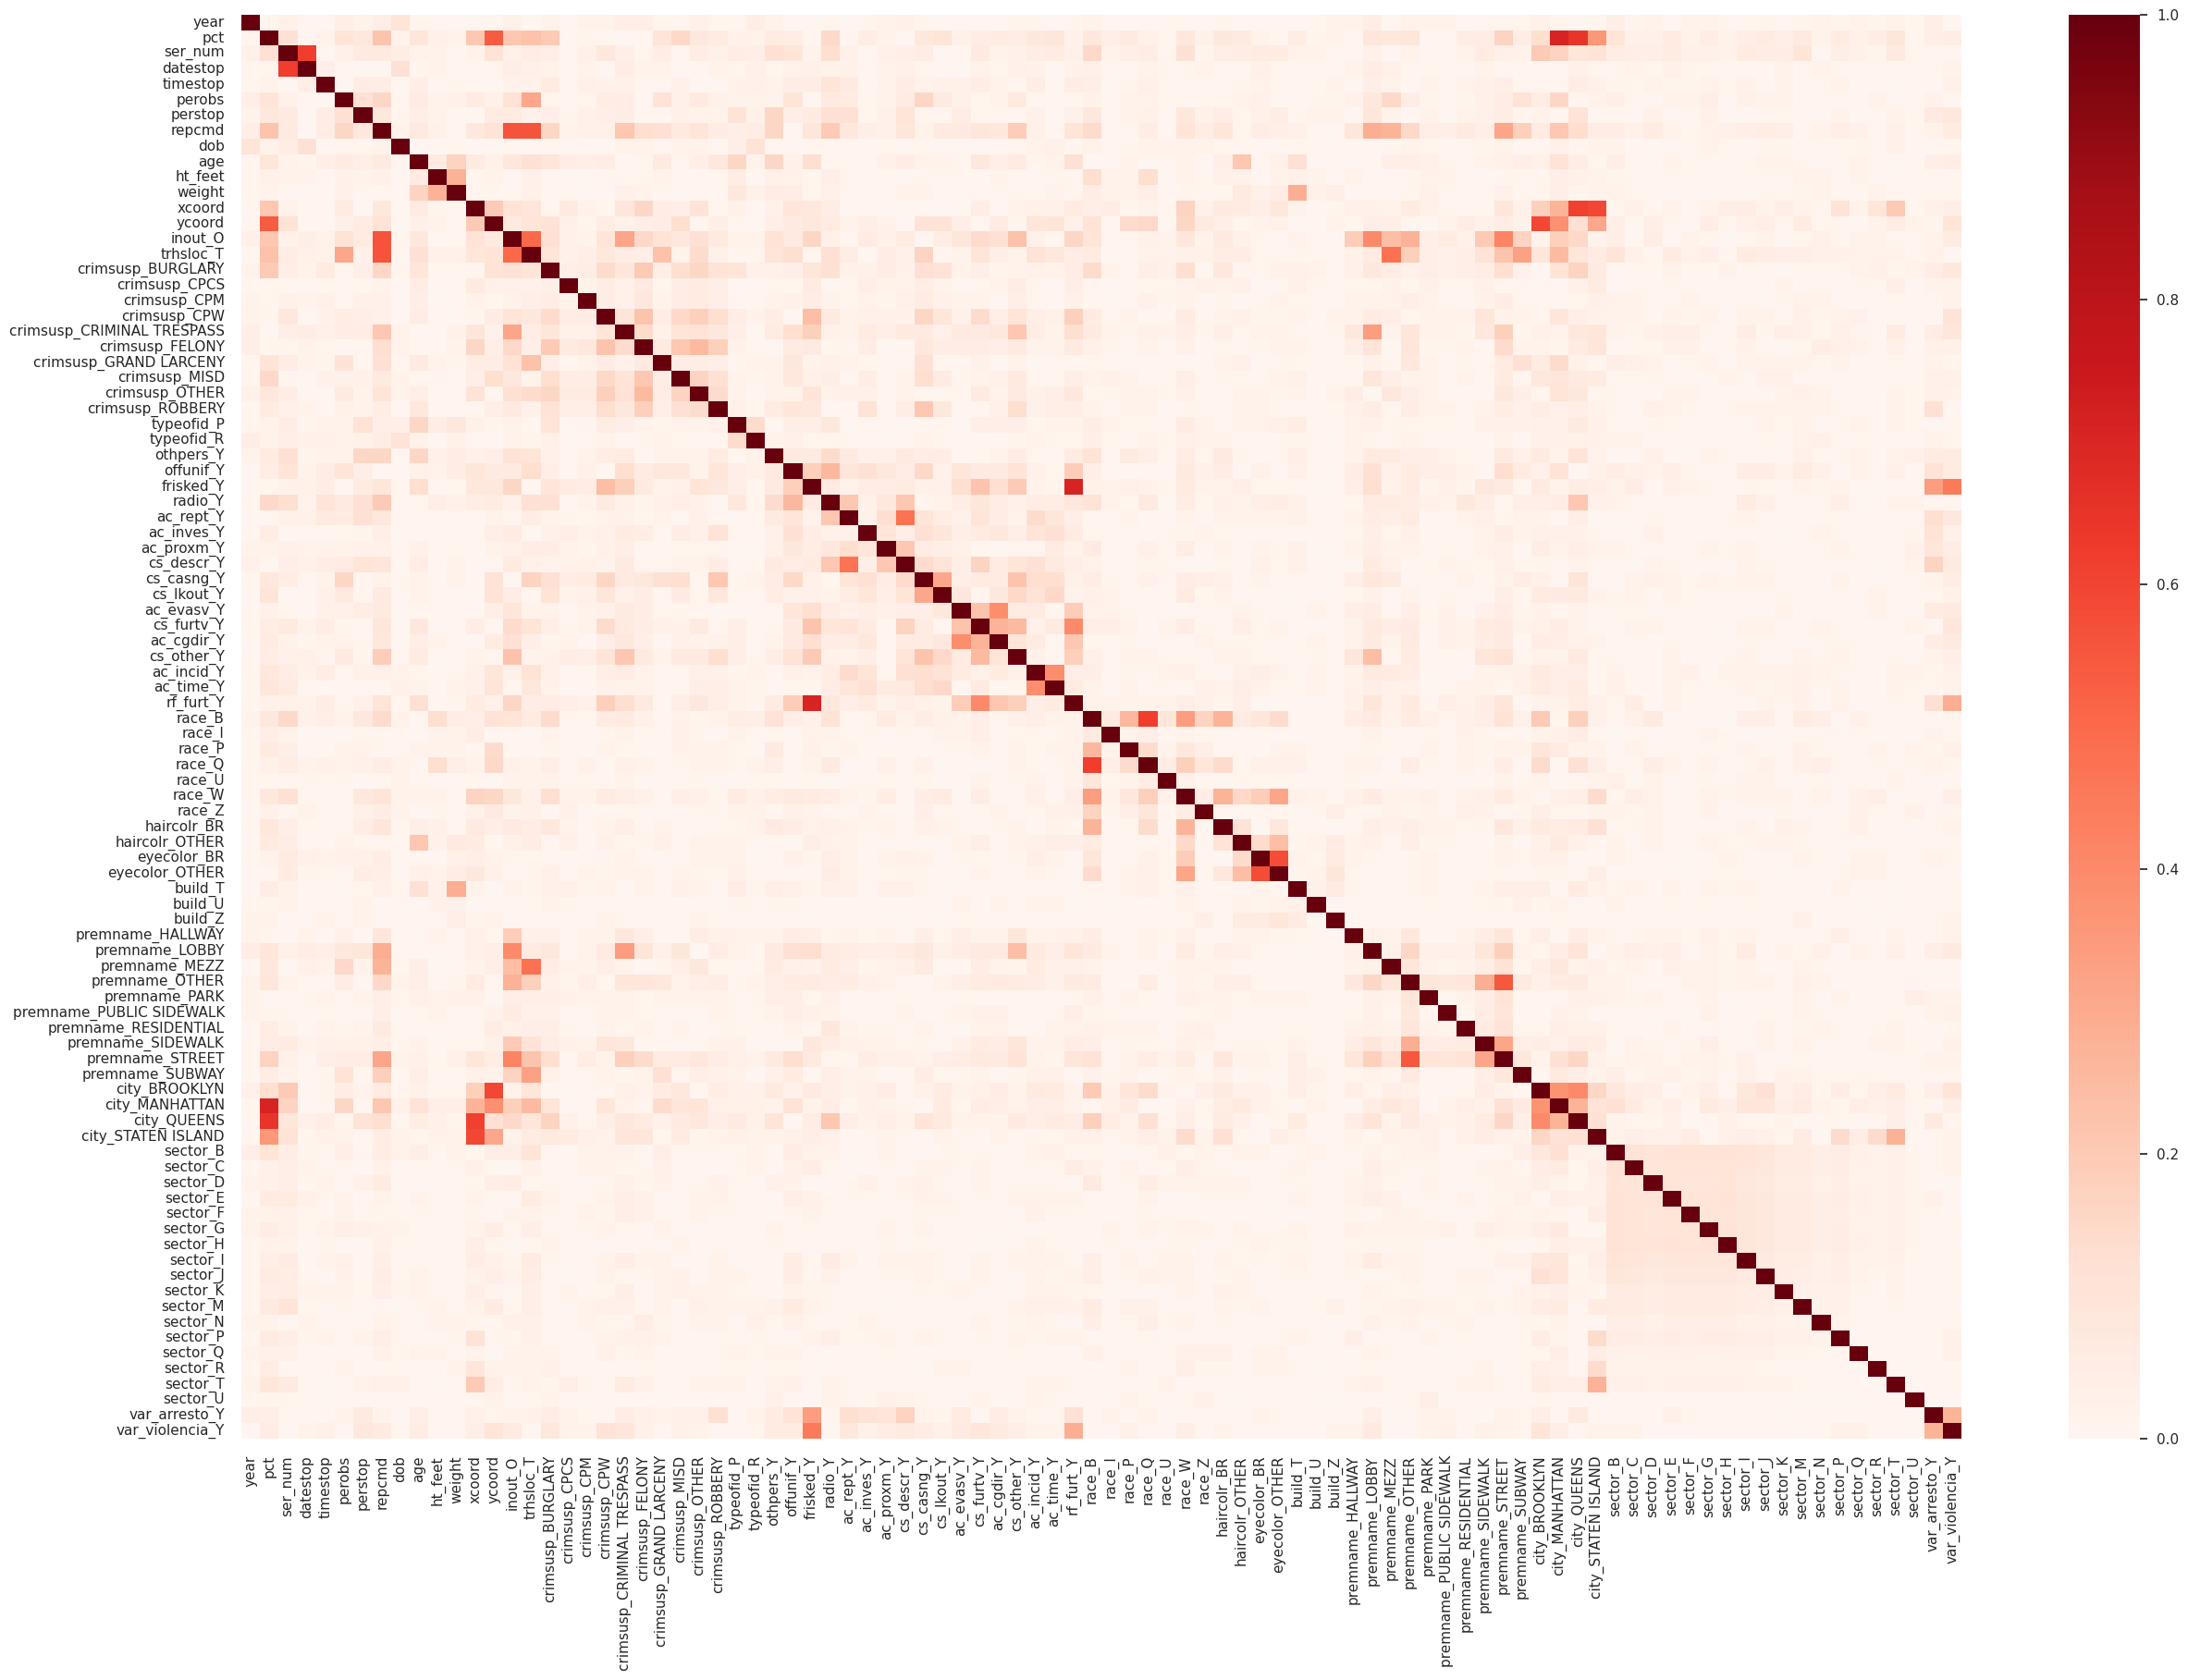

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(30, 20))

# Crear un mapa de calor de la matriz de correlación absoluta
sns.heatmap(abs(df3.corr().round(2)), annot=False, cmap='Reds', annot_kws={"size": 5})

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear X excluyendo las columnas 'var_arresto_Y' y 'var_violencia_Y'
X = df3.drop(columns=['var_arresto_Y', 'var_violencia_Y'])

# Imprimir las dimensiones de X
X.shape

(10548, 90)

In [ ]:
# Crear las variables objetivo y_arresto y y_violencia
y_arresto = df3['var_arresto_Y']
y_violencia = df3['var_violencia_Y']

In [ ]:
# Contar las ocurrencias de cada valor único en y_arresto
y_arresto.value_counts()

0    8825
1    1723
Name: var_arresto_Y, dtype: int64

In [ ]:
# Contar las ocurrencias de cada valor único en y_violencia
y_violencia.value_counts()

0    7690
1    2858
Name: var_violencia_Y, dtype: int64

In [ ]:
# Definir los ratios de sampling_strategy para oversampling y undersampling
sampling_strategy_over = 0.5
sampling_strategy_under = 0.5

# Crear instancias de SMOTE y RandomUnderSampler
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

# Definir los pasos de la pipeline con oversampling y undersampling
steps = [('o', over), ('u', under)]

# Crear la pipeline
pipeline = Pipeline(steps=steps)

In [ ]:
# Aplicar la pipeline para balancear las clases en y_arresto
X_arresto_bal, y_arresto_bal = pipeline.fit_resample(X, y_arresto)

# Imprimir las estadísticas de las clases después del balanceo
print(f'Arresto: {Counter(y_arresto_bal)}')

Arresto: Counter({0: 8824, 1: 4412})


In [ ]:
# Aplicar la pipeline para balancear las clases en y_violencia
X_violencia_bal, y_violencia_bal = pipeline.fit_resample(X, y_violencia)

# Imprimir las estadísticas de las clases después del balanceo
print(f'Violencia: {Counter(y_violencia_bal)}')

Violencia: Counter({0: 7690, 1: 3845})


In [ ]:
# Concatenar las variables predictoras y la variable objetivo para la tarea de arresto
df_arresto_bal = pd.concat([X_arresto_bal, y_arresto_bal], axis=1)

# Concatenar las variables predictoras y la variable objetivo para la tarea de violencia
df_violencia_bal = pd.concat([X_violencia_bal, y_violencia_bal], axis=1)

## Modelado

División del Conjunto de Datos
- Separación del conjunto de datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Conjuntos de entrenamiento y prueba para la tarea de arresto
X_train_arresto = df_arresto_bal[df_arresto_bal.columns.drop('var_arresto_Y')][df_arresto_bal['year']==2009]
y_train_arresto = df_arresto_bal['var_arresto_Y'][df_arresto_bal['year']==2009]
X_test_arresto = df_arresto_bal[df_arresto_bal.columns.drop('var_arresto_Y')][df_arresto_bal['year']==2010]
y_test_arresto = df_arresto_bal['var_arresto_Y'][df_arresto_bal['year']==2010]

# Conjuntos de entrenamiento y prueba para la tarea de violencia
X_train_violencia = df_violencia_bal[df_violencia_bal.columns.drop('var_violencia_Y')][df_violencia_bal['year']==2009]
y_train_violencia = df_violencia_bal['var_violencia_Y'][df_violencia_bal['year']==2009]
X_test_violencia = df_violencia_bal[df_violencia_bal.columns.drop('var_violencia_Y')][df_violencia_bal['year']==2010]
y_test_violencia = df_violencia_bal['var_violencia_Y'][df_violencia_bal['year']==2010]


Selección y Ajuste de Modelos
- Selección de modelos de clasificación (Logistic Regression, SVM)
- Ajuste de hiperparámetros mediante validación cruzada.

In [ ]:
# Entrenar modelo de regresión logística para la tarea de arresto
modelo_LR_arresto = LogisticRegression().fit(X_train_arresto, y_train_arresto)

# Entrenar modelo de regresión logística para la tarea de violencia
modelo_LR_violencia = LogisticRegression().fit(X_train_violencia, y_train_violencia)

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros para SVC
param_grid_svc = {'C': [1, 10, 100],
                  'gamma': [0.0000001, 0.1, 1.0]}

# Ajustar el modelo SVC para la tarea de arresto
modelo_SVC_arresto = GridSearchCV(SVC(), param_grid_svc, cv=5, n_jobs=1).fit(X_train_arresto, y_train_arresto)

# Ajustar el modelo SVC para la tarea de violencia
modelo_SVC_violencia = GridSearchCV(SVC(), param_grid_svc, cv=5, n_jobs=1).fit(X_train_violencia, y_train_violencia)

In [ ]:
# Obtener los mejores hiperparámetros para el modelo de SVC en el caso de arresto
mejores_hiperparametros_arresto = modelo_SVC_arresto.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores Hiperparámetros para Arresto:", mejores_hiperparametros_arresto)

{'C': 10, 'gamma': 1e-07}

In [ ]:
# Obtener los mejores hiperparámetros para el modelo de SVC en el caso de arresto
mejores_hiperparametros_violencia = modelo_SVC_violencia.best_params_
# Imprimir los mejores hiperparámetros
print("Mejores Hiperparámetros para Violencia:", mejores_hiperparametros_violencia)

{'C': 10, 'gamma': 1e-07}

In [ ]:
# Mejores hiperparámetros para arresto
mejores_hiperparametros_arresto = {'C': 10, 'gamma': 0.0000001}
modelo_SVC_arresto_best = SVC(**mejores_hiperparametros_arresto).fit(X_train_arresto, y_train_arresto)

# Mejores hiperparámetros para violencia
mejores_hiperparametros_violencia = {'C': 10, 'gamma': 0.0000001}
modelo_SVC_violencia_best = SVC(**mejores_hiperparametros_violencia).fit(X_train_violencia, y_train_violencia)

Evaluación de Modelos
- Evaluación de modelos mediante métricas como precisión, recall y F1-score.
- Comparación de modelos y selección del mejor modelo.

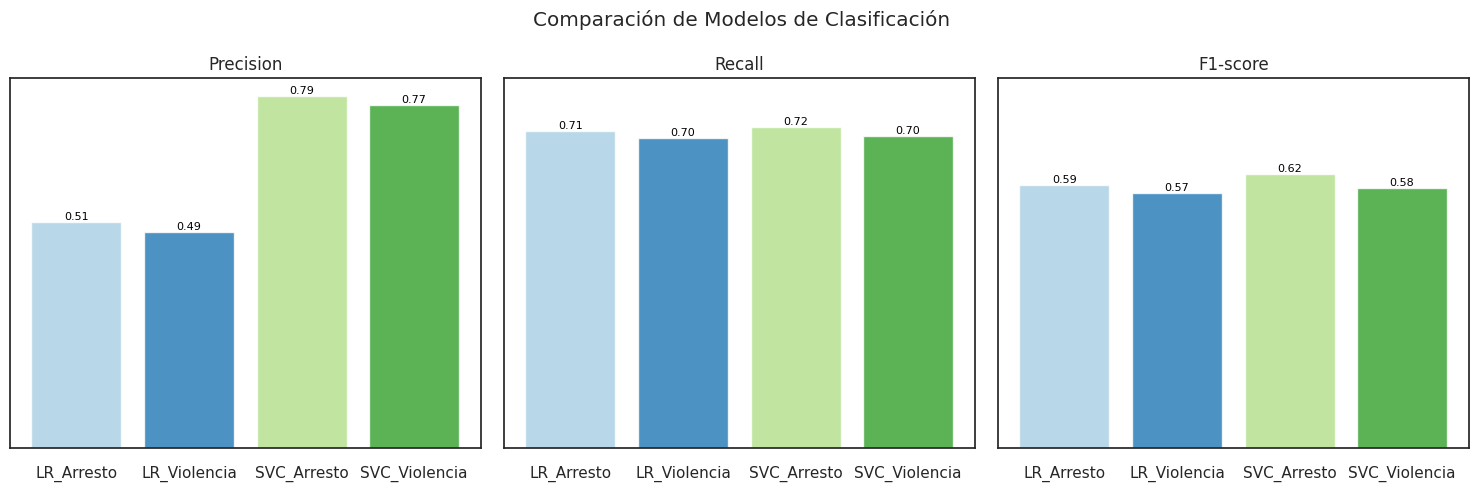

In [ ]:
# Obtener resultados para los modelos
resultados_LR_arresto = classification_report(y_test_arresto, modelo_LR_arresto.predict(X_test_arresto), output_dict=True)
resultados_LR_violencia = classification_report(y_test_violencia, modelo_LR_violencia.predict(X_test_violencia), output_dict=True)
resultados_SVC_arresto = classification_report(y_test_arresto, modelo_SVC_arresto_best.predict(X_test_arresto), output_dict=True)
resultados_SVC_violencia = classification_report(y_test_violencia, modelo_SVC_violencia_best.predict(X_test_violencia), output_dict=True)

# Métricas y modelos a comparar
metricas = ['precision', 'recall', 'f1-score']
modelos = ['LR_Arresto', 'LR_Violencia', 'SVC_Arresto', 'SVC_Violencia']

colores = plt.cm.Paired(np.arange(len(modelos)))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, metrica in enumerate(metricas):
    valores_metrica = [
        resultados_LR_arresto['weighted avg'][metrica],
        resultados_LR_violencia['weighted avg'][metrica],
        resultados_SVC_arresto['weighted avg'][metrica],
        resultados_SVC_violencia['weighted avg'][metrica]
    ]

    bars = axs[i].bar(modelos, valores_metrica, color=colores, alpha=0.8)
    axs[i].set_title(metrica.capitalize())

    for bar, modelo in zip(bars, modelos):
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8, color='black')

for ax in axs:
    ax.yaxis.set_visible(False)

fig.suptitle('Comparación de Modelos de Clasificación')
plt.tight_layout()
plt.show()

Selección y Ajuste de Modelos
- Selección de modelos de clasificación (Decision Trees, AdaBoost, Gradient Boosting).
- Ajuste de hiperparámetros mediante validación cruzada.

In [ ]:
# Grilla de parámetros para el modelo de árbol de decisión en caso de arresto
param_grid_tree_arresto = {
    'min_samples_split': [0.1, 0.5, 0.9],
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [0.1, 0.5]
}

# Ajuste del modelo de árbol de decisión para arresto con validación cruzada
modelo_tree_arresto = GridSearchCV(DecisionTreeClassifier(), param_grid_tree_arresto, cv=5, n_jobs=1).fit(X_train_arresto, y_train_arresto)

# Grilla de parámetros para el modelo de árbol de decisión en caso de violencia
param_grid_tree_violencia = {
    'min_samples_split': [0.1, 0.5, 0.9],
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [0.1, 0.5]
}

# Ajuste del modelo de árbol de decisión para violencia con validación cruzada
modelo_tree_violencia = GridSearchCV(DecisionTreeClassifier(), param_grid_tree_violencia, cv=5, n_jobs=1).fit(X_train_violencia, y_train_violencia)

In [ ]:
# Imprimir los mejores parámetros encontrados para el modelo de árbol de decisión en el caso de arresto
print("Mejores parámetros para el modelo de árbol de decisión en el caso de arresto:")
print(modelo_tree_arresto.best_params_)

{'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

In [ ]:
# Imprimir los mejores parámetros encontrados para el modelo de árbol de decisión en el caso de violencia
print("Mejores parámetros para el modelo de árbol de decisión en el caso de violencia:")
print(modelo_tree_violencia.best_params_)

{'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

In [ ]:
# Ajustar modelos de árbol de decisión para arresto y violencia con los mejores hiperparámetros
modelo_tree_arresto_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.1, min_samples_split=0.1).fit(X_train_arresto, y_train_arresto)
modelo_tree_violencia_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.1, min_samples_split=0.1).fit(X_train_violencia, y_train_violencia)

In [ ]:
# Definir la cuadrícula de hiperparámetros para AdaBoost
param_grid_ADA = {'learning_rate': [0.1, 0.5],
                  'n_estimators': [50, 1000, 2000]}

# Ajustar modelos AdaBoost para arresto y violencia con búsqueda de cuadrícula
modelo_ADA_arresto = GridSearchCV(AdaBoostClassifier(), param_grid_ADA, cv=5, n_jobs=1).fit(X_train_arresto, y_train_arresto)
modelo_ADA_violencia = GridSearchCV(AdaBoostClassifier(), param_grid_ADA, cv=5, n_jobs=1).fit(X_train_violencia, y_train_violencia)

In [ ]:
print("Mejores parámetros para el modelo AdaBoost en el caso de arresto:")
print(modelo_ADA_arresto.best_params_)

{'learning_rate': 0.1, 'n_estimators': 2000}

In [ ]:
print("Mejores parámetros para el modelo AdaBoost en el caso de violencia:")
print(modelo_ADA_violencia.best_params_)

{'learning_rate': 0.5, 'n_estimators': 2000}

In [ ]:
# Ajuste de modelos AdaBoost con los mejores hiperparámetros encontrados para el caso de arresto
modelo_ADA_arresto_best = AdaBoostClassifier(learning_rate=0.1, n_estimators=2000).fit(X_train_arresto, y_train_arresto)

# Ajuste de modelos AdaBoost con los mejores hiperparámetros encontrados para el caso de violencia
modelo_ADA_violencia_best = AdaBoostClassifier(learning_rate=0.5, n_estimators=2000).fit(X_train_violencia, y_train_violencia)

In [ ]:
# Definición de la cuadrícula de hiperparámetros para Gradient Boosting
param_grid_GB = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 500, 2000],
    'subsample': [0.5, 0.9]
}

# Ajuste de modelos Gradient Boosting con búsqueda de cuadrícula para el caso de arresto
modelo_GB_arresto = GridSearchCV(GradientBoostingClassifier(), param_grid_GB, cv=5, n_jobs=1).fit(X_train_arresto, y_train_arresto)

# Ajuste de modelos Gradient Boosting con búsqueda de cuadrícula para el caso de violencia
modelo_GB_violencia = GridSearchCV(GradientBoostingClassifier(), param_grid_GB, cv=5, n_jobs=1).fit(X_train_violencia, y_train_violencia)

In [ ]:
# Imprimir los mejores parámetros encontrados para el modelo Gradient Boosting en el caso de arresto
print("Mejores parámetros para el modelo Gradient Boosting en el caso de arresto:")
print(modelo_GB_arresto.best_params_)

{'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.9}

In [ ]:
# Imprimir los mejores parámetros encontrados para el modelo Gradient Boosting en el caso de violencia
print("Mejores parámetros para el modelo Gradient Boosting en el caso de violencia:")
print(modelo_GB_violencia.best_params_)

{'learning_rate': 0.1, 'n_estimators': 2000, 'subsample': 0.5}

In [ ]:
# Crear y ajustar el modelo Gradient Boosting con los mejores hiperparámetros para arresto
modelo_GB_arresto_best = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.9).fit(X_train_arresto, y_train_arresto)

# Crear y ajustar el modelo Gradient Boosting con los mejores hiperparámetros para violencia
modelo_GB_violencia_best = GradientBoostingClassifier(learning_rate=0.1, n_estimators=2000, subsample=0.5).fit(X_train_violencia, y_train_violencia)

Evaluación de Modelos
- Evaluación de modelos mediante métricas como precisión, recall y F1-score.
- Comparación de modelos y selección del mejor modelo.

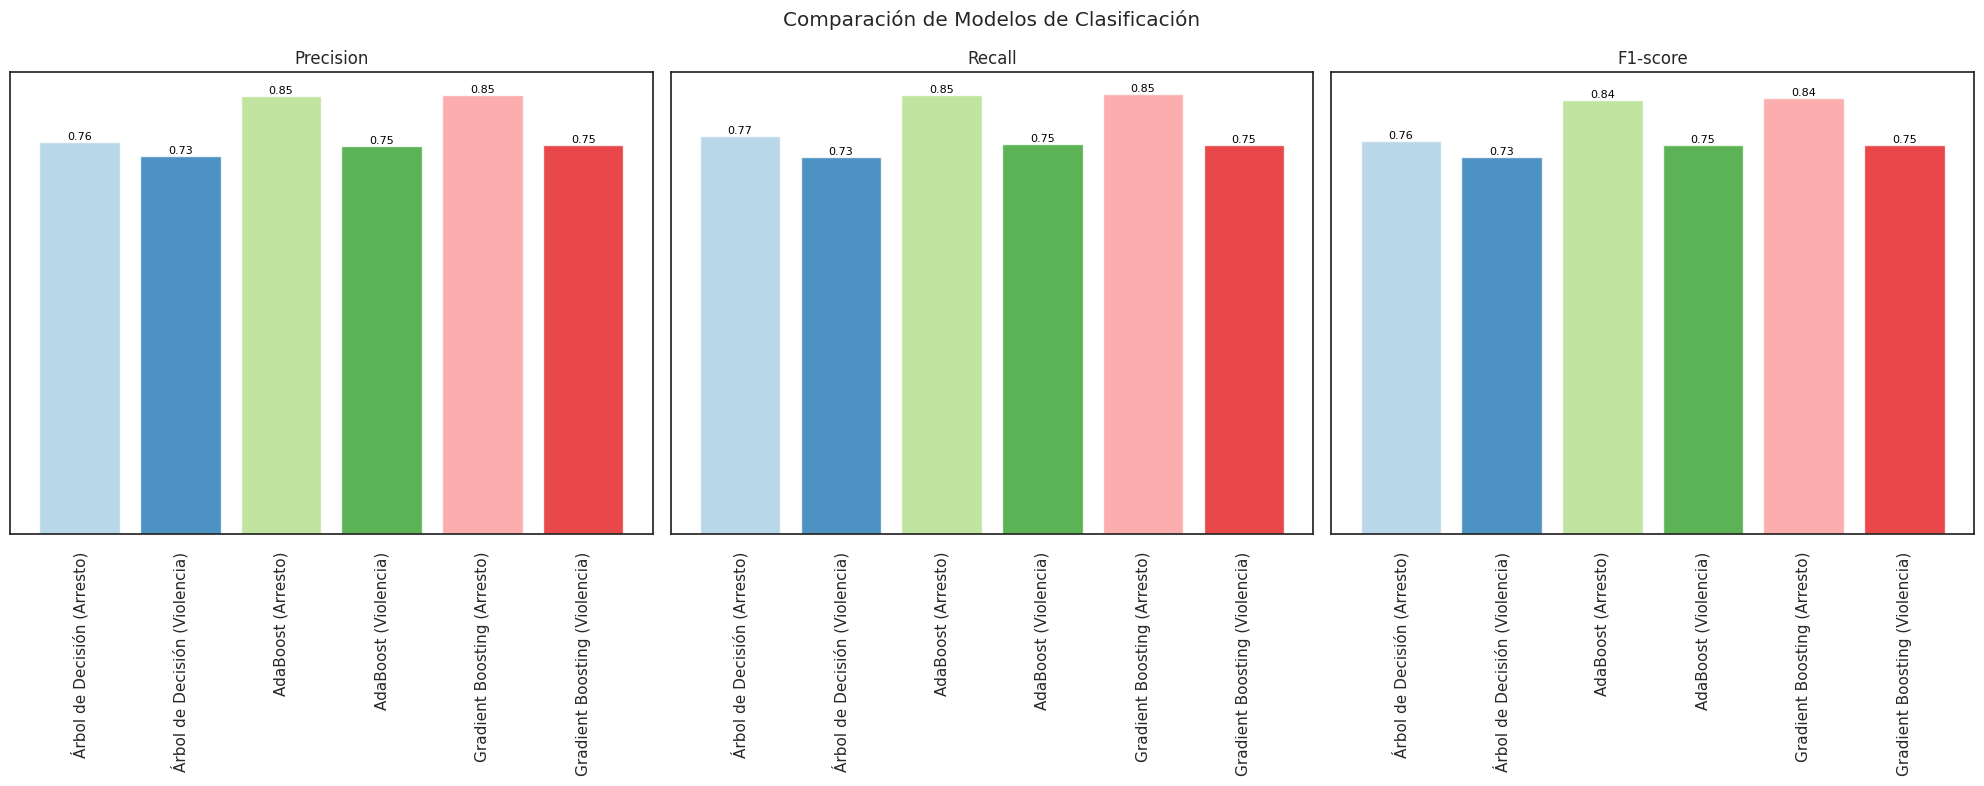

In [ ]:
# Resultados de los modelos como diccionarios
resultados_tree_arresto = classification_report(y_test_arresto, modelo_tree_arresto_best.predict(X_test_arresto), output_dict=True)
resultados_tree_violencia = classification_report(y_test_violencia, modelo_tree_violencia_best.predict(X_test_violencia), output_dict=True)
resultados_ADA_arresto = classification_report(y_test_arresto, modelo_ADA_arresto_best.predict(X_test_arresto), output_dict=True)
resultados_ADA_violencia = classification_report(y_test_violencia, modelo_ADA_violencia_best.predict(X_test_violencia), output_dict=True)
resultados_GB_arresto = classification_report(y_test_arresto, modelo_GB_arresto_best.predict(X_test_arresto), output_dict=True)
resultados_GB_violencia = classification_report(y_test_violencia, modelo_GB_violencia_best.predict(X_test_violencia), output_dict=True)

# Métricas y modelos a comparar
metricas = ['precision', 'recall', 'f1-score']
modelos = ['Árbol de Decisión (Arresto)', 'Árbol de Decisión (Violencia)', 'AdaBoost (Arresto)', 'AdaBoost (Violencia)', 'Gradient Boosting (Arresto)', 'Gradient Boosting (Violencia)']

colores = plt.cm.Paired(np.arange(len(modelos)))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 8), sharey=True)

for i, metrica in enumerate(metricas):
    valores_metrica = [
        resultados_tree_arresto['weighted avg'][metrica], resultados_tree_violencia['weighted avg'][metrica],
        resultados_ADA_arresto['weighted avg'][metrica], resultados_ADA_violencia['weighted avg'][metrica],
        resultados_GB_arresto['weighted avg'][metrica], resultados_GB_violencia['weighted avg'][metrica]
    ]

    bars = axs[i].bar(modelos, valores_metrica, color=colores, alpha=0.8)
    axs[i].set_title(metrica.capitalize())
    axs[i].tick_params(axis='x', rotation=45, labelrotation=90)

    for bar, modelo in zip(bars, modelos):
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8, color='black')

for ax in axs:
    ax.yaxis.set_visible(False)

fig.suptitle('Comparación de Modelos de Clasificación')
plt.tight_layout()
plt.show()

## Predicciones

In [ ]:
predict_arresto = modelo_GB_arresto_best.predict(X_test_arresto)

for i in ['race_B', 'race_I', 'race_P', 'race_Q', 'race_U', 'race_W', 'race_Z']:
    temp = pd.DataFrame(zip(np.array(X_test_arresto[i]), predict_arresto))

    # Para la raza actual
    probabilidad_arresto = len(temp[np.logical_and(temp[0] == 1, temp[1] == 1)]) / len(temp[0])
    print(f'La probabilidad de ser arrestado por ser de raza {i} es: {probabilidad_arresto * 100:.2f}%')

    # Para no ser de la raza actual
    probabilidad_no_arresto = len(temp[np.logical_and(temp[0] == 0, temp[1] == 1)]) / len(temp[0])
    print(f'La probabilidad de ser arrestado por no ser de la raza {i} es: {probabilidad_no_arresto * 100:.2f}%')
    print('\n')

La probabilidad de ser arrestado por ser de raza race_B es: 7.85%
La probabilidad de ser arrestado por no ser de la raza race_B es: 13.09%


La probabilidad de ser arrestado por ser de raza race_I es: 0.02%
La probabilidad de ser arrestado por no ser de la raza race_I es: 20.92%


La probabilidad de ser arrestado por ser de raza race_P es: 0.29%
La probabilidad de ser arrestado por no ser de la raza race_P es: 20.65%


La probabilidad de ser arrestado por ser de raza race_Q es: 2.82%
La probabilidad de ser arrestado por no ser de la raza race_Q es: 18.11%


La probabilidad de ser arrestado por ser de raza race_U es: 0.08%
La probabilidad de ser arrestado por no ser de la raza race_U es: 20.86%


La probabilidad de ser arrestado por ser de raza race_W es: 1.04%
La probabilidad de ser arrestado por no ser de la raza race_W es: 19.90%


La probabilidad de ser arrestado por ser de raza race_Z es: 0.19%
La probabilidad de ser arrestado por no ser de la raza race_Z es: 20.75%




In [ ]:
predict_arresto = modelo_GB_arresto_best.predict(X_test_arresto)

for i in ['city_BROOKLYN', 'city_MANHATTAN', 'city_QUEENS', 'city_STATEN ISLAND']:
    temp = pd.DataFrame(zip(np.array(X_test_arresto[i]), predict_arresto))

    # Para la ciudad actual
    probabilidad_arresto = len(temp[np.logical_and(temp[0] == 1, temp[1] == 1)]) / len(temp[0])
    print(f'La probabilidad de ser arrestado por ser de la ciudad de {i} es: {probabilidad_arresto * 100:.2f}%')

    # Para no ser de la ciudad actual
    probabilidad_no_arresto = len(temp[np.logical_and(temp[0] == 0, temp[1] == 1)]) / len(temp[0])
    print(f'La probabilidad de ser arrestado por no ser de la ciudad de {i} es: {probabilidad_no_arresto * 100:.2f}%')
    print('\n')

La probabilidad de ser arrestado por ser de la ciudad de city_BROOKLYN es: 3.21%
La probabilidad de ser arrestado por no ser de la ciudad de city_BROOKLYN es: 17.73%


La probabilidad de ser arrestado por ser de la ciudad de city_MANHATTAN es: 2.54%
La probabilidad de ser arrestado por no ser de la ciudad de city_MANHATTAN es: 18.40%


La probabilidad de ser arrestado por ser de la ciudad de city_QUEENS es: 3.99%
La probabilidad de ser arrestado por no ser de la ciudad de city_QUEENS es: 16.95%


La probabilidad de ser arrestado por ser de la ciudad de city_STATEN ISLAND es: 0.61%
La probabilidad de ser arrestado por no ser de la ciudad de city_STATEN ISLAND es: 20.33%


